# Data acquisition and preprocessing

### Installing requirements

In [10]:
!pip install -r requirements

### Moving the downloaded Kaggle API key to the users Kaggle directory

In [54]:
import os
import shutil

os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)
shutil.copy('kaggle.json', os.path.expanduser("~/.kaggle/kaggle.json"))  # Copy the file

'C:\\Users\\tmate/.kaggle/kaggle.json'

### Downloading the BirdCLEF 2023 .zip file dataset to the project folder

In [55]:
!kaggle competitions download -c birdclef-2023

birdclef-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


### Extract the downloaded dataset to the data directory

In [56]:
import zipfile

with zipfile.ZipFile('birdclef-2023.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

## Data preprocessing

In [57]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load the dataset
Here we load the downloaded BirdCLEF dataset based on the train_metadata.csv file, which contains the metadata about the dataset.

In [58]:
audio_data_dir = 'data/train_audio/'
csv_file = 'data/train_metadata.csv'
data = pd.read_csv(csv_file)
data.head(10)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg
5,abethr1,['rbsrob1'],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/379322,abethr1/XC379322.ogg
6,abethr1,[],"['call', 'song']",-2.9965,37.6244,Turdus tephronotus,African Bare-eyed Thrush,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/432639,abethr1/XC432639.ogg
7,abethr1,[],['song'],-4.0904,37.8807,Turdus tephronotus,African Bare-eyed Thrush,Peter Ericsson,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/467121,abethr1/XC467121.ogg
8,abethr1,[],['song'],-4.0904,37.8807,Turdus tephronotus,African Bare-eyed Thrush,Peter Ericsson,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/467122,abethr1/XC467122.ogg
9,abethr1,[],"['adult', 'sex uncertain', 'song']",4.8403,38.6988,Turdus tephronotus,African Bare-eyed Thrush,Barry Edmonston,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/531557,abethr1/XC531557.ogg


Then we collect the labels and the durations in seconds of each audio file to analyze the dataset.

In [59]:
labels_arr = data['primary_label']
audio_data_filename_arr = data['filename']

waveforms = []
sample_rates = []
metadata = []
num_of_not_exist = 0

for file_name in audio_data_filename_arr:
    audio_file = os.path.join(audio_data_dir, file_name)

    if os.path.exists(audio_file):
        waveform, sample_rate = librosa.load(audio_file, sr=None)

        waveforms.append(librosa.get_duration(y=waveform, sr=sample_rate))
        sample_rates.append(sample_rate)
        metadata.append(
            {
                "label": file_name.split('/')[0],
                "file_name": file_name,
                "duration": librosa.get_duration(y=waveform, sr=sample_rate)
            }
        )
    else:
        num_of_not_exist += 1

### We print some informations about the lenght of the audio dataset 

In [60]:
print('min waveform ', np.min(waveforms))
print('max waveform  ', np.max(waveforms))
print('mean waveform  ', np.mean(waveforms))
print('min sample rate ', np.min(sample_rates))
print('max sample rate ', np.max(sample_rates))
print('num of not exist ', num_of_not_exist)

min waveform  0.548
max waveform   2373.528
mean waveform   40.88556542190543
min sample rate  32000
max sample rate  32000
num of not exist  0


### This histogram shows how many audio files have a certain lenght. We can see that most of the audiofiles are less than 225 second, but we also have a ~2374 second audio file, which is the largest one.

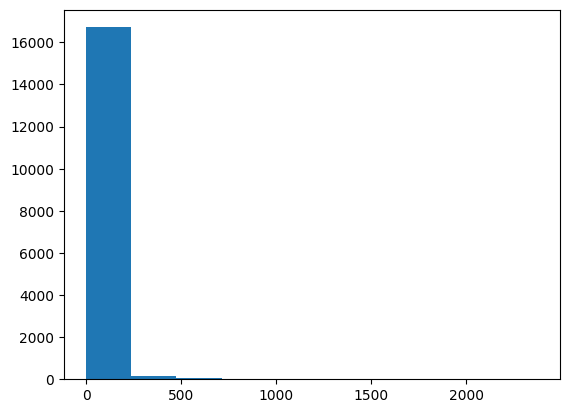

In [61]:
plt.hist(x=waveforms)
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

## Filtering the datas:
- we make some datafiltering: we filter out the datas, that are less than 2 second, and we also cut out the files that are more than 60 seconds to fit the dataset so the neural network can train on it

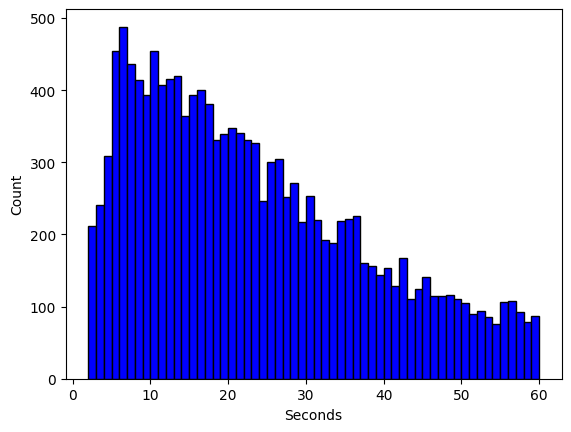

In [62]:
filteredWaveforms = []

for i in range(len(waveforms)):
    if 2 <= waveforms[i] <= 60:
        filteredWaveforms.append(waveforms[i])

plt.hist(x=filteredWaveforms, bins=58, color='b', edgecolor='black')
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

## Total time for each label
- in this section, we are vizualizing how much audio time each class have

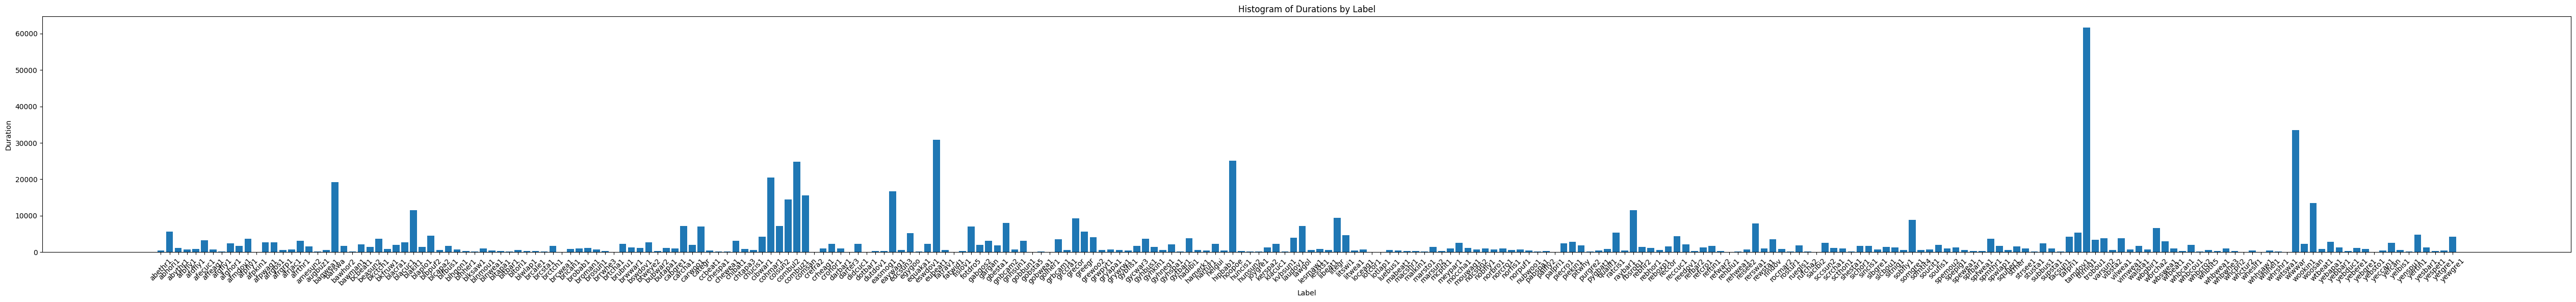

In [63]:
grouped_data = {}

for item in metadata:
    label = item["label"]
    duration = item["duration"]

    if label in grouped_data:
        grouped_data[label] += duration
    else:
        grouped_data[label] = duration

labels = grouped_data.keys()
durations = grouped_data.values()

plt.figure(figsize=(64, 6))
plt.bar(labels, durations)
plt.xlabel("Label")
plt.ylabel("Duration")
plt.title("Histogram of Durations by Label")
plt.xticks(rotation=45)  # Rotate labels for readability

plt.show()

## Total time for each label - filtered
- after the data filtering we see how much more balanced the dataset became, which is crucial for the classification task

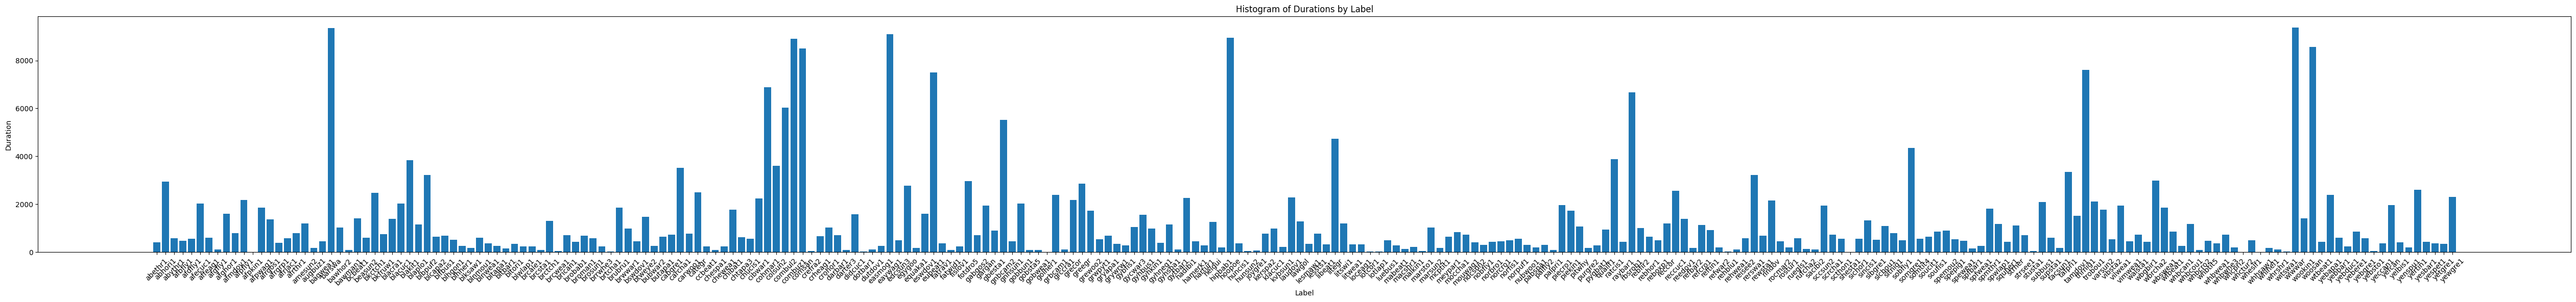

In [64]:
min_duration = 2  # in seconds
max_duration = 60  # in seconds
filtered_grouped_data = {}

for item in metadata:
    label = item["label"]
    duration = item["duration"]

    if min_duration <= duration <= max_duration:
        if label in filtered_grouped_data:
            filtered_grouped_data[label] += duration
        else:
            filtered_grouped_data[label] = duration

# Extract labels and durations from grouped_data
filtered_labels = filtered_grouped_data.keys()
filtered_durations = filtered_grouped_data.values()

plt.figure(figsize=(64, 6))
plt.bar(filtered_labels, filtered_durations)
plt.xlabel("Label")
plt.ylabel("Duration")
plt.title("Histogram of Durations by Label")
plt.xticks(rotation=45)  # Rotate labels for readability

# Display the pie chart
plt.show()

## Check the count of the remained labels
- we check whether we lost any label after the data filtering

In [65]:
if grouped_data.__sizeof__() == filtered_grouped_data.__sizeof__():
    print(
        "The filtered dataset is also contains all labels. We have not lost any label(s) with the previous data augmentation step.")
else:
    print("The filtered dataset does not contain all labels. We lost label(s) with the previous data augemntation.")

The filtered dataset is also contains all labels. We have not lost any label(s) with the previous data augmentation step.


##

### Base dataset

In [66]:
base_df = pd.DataFrame(list(grouped_data.items()), columns=["label", "duration"])
base_df.describe()

,duration
count,264.000000
mean,2623.645317
std,5762.912719
min,7.752000
25%,383.008469
50%,960.317844
75%,2333.887164
max,61606.550563


### Filtered dataset

In [67]:
filtered_df = pd.DataFrame(list(filtered_grouped_data.items()), columns=["label", "duration"])
filtered_df.describe()

,duration
count,264.000000
mean,1232.983219
std,1780.735696
min,7.752000
25%,265.251555
50%,597.708797
75%,1396.874031
max,9367.172812


## Data visualization

In [70]:
ogg_file = audio_data_dir + metadata[0]["file_name"]

example_waveform, example_sample_rate = librosa.load(ogg_file, sr=None)

data/train_audio/abethr1/XC128013.ogg


### Waveform
- in this section we are vizualizing the audio data according to its waveform

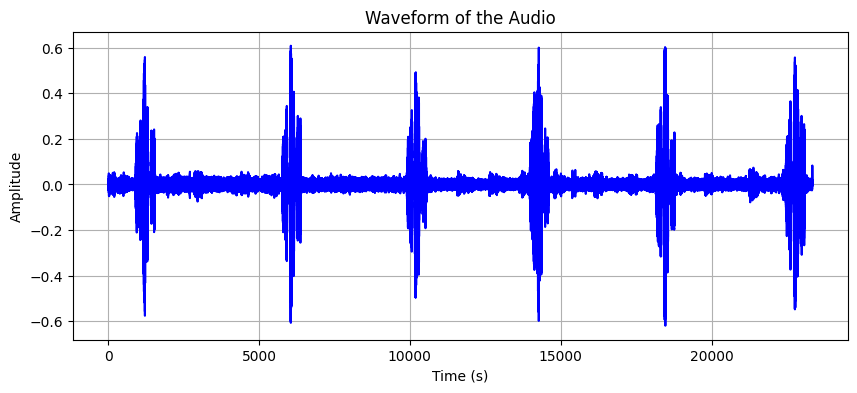

In [75]:
time = librosa.times_like(example_waveform, sr=example_sample_rate)

plt.figure(figsize=(10, 4))
plt.plot(time, example_waveform, color='b')
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.show()

### Mel Spectogram
- in this section we are vizualizing the audio data's Mel Spectogram 

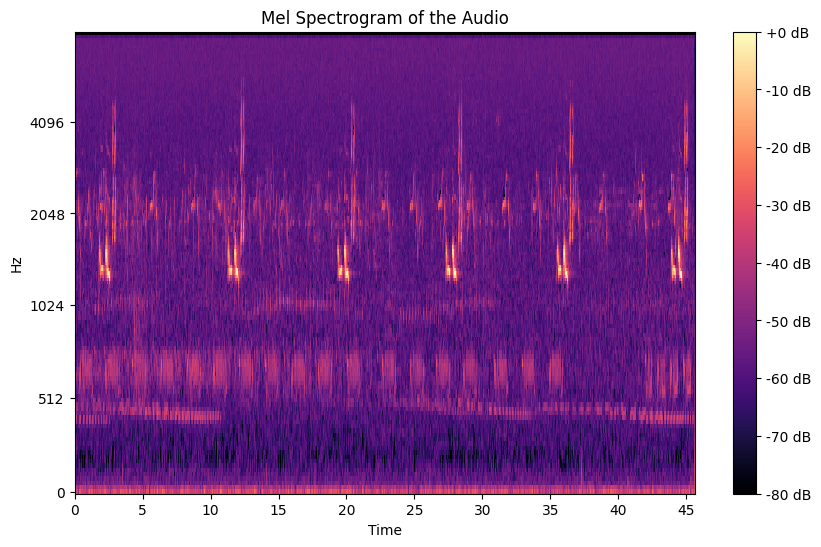

In [78]:
mel_spectrogram = librosa.feature.melspectrogram(y=example_waveform, sr=example_sample_rate)

mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=example_sample_rate, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram of the Audio")
plt.show()

## Save filtered data path
- in this section we are saving the data filtration into a new metadata file which we can be loaded later in the training part 

In [80]:
df = pd.DataFrame(metadata)

csv_file = "train_metadata_for_training.csv"

df[['file_name']].to_csv(csv_file, index=False)